<a href="https://colab.research.google.com/github/LevonaHayoun/3d_Unet_Segmentation/blob/main/Check_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import onnxruntime" || pip install -q onnxruntime
%matplotlib inline

2024-07-10 14:38:54.914796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 14:38:54.914850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 14:38:54.916360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 14:38:56.031367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import os
import tempfile
from monai.data import Dataset, DataLoader
from monai.transforms.compose import Compose
import shutil
import time
from monai.config import print_config
from monai.data import decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    Resized,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import first,set_determinism

import torch

import matplotlib.pyplot as plt
import numpy as np
import cv2

set_determinism(seed=0)

"""#Convert to Binary classes"""

class ConvertToBinaryClasses(MapTransform):



    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result=[]
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key]== 255))

            d[key] = torch.stack(result, axis=0).float()

        return d



In [ ]:
"""## Setup transforms for training and validation"""

train_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys="image"),
    EnsureTyped(keys=["image", "label"]),
    ConvertToBinaryClasses(keys="label"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    #Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    #RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
    RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
])


val_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys="image"),
    EnsureTyped(keys=["image", "label"]),
    ConvertToBinaryClasses(keys="label"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    #Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

In [ ]:
"""# Importing data"""

import glob
data_dir='/content/drive/MyDrive/Cases/theirs/trainn'
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
train_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files = train_dicts


data_dir='/content/drive/MyDrive/Cases/theirs/vall'
val_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
val_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
val_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_images, val_labels)]
val_files = val_dicts


val_files

[{'image': '/content/drive/MyDrive/Cases/theirs/vall/imagesTr/img_case_61.nii.gz',
  'label': '/content/drive/MyDrive/Cases/theirs/vall/labelsTr/lbl_case_61.nii.gz'},
 {'image': '/content/drive/MyDrive/Cases/theirs/vall/imagesTr/img_case_6588.nii.gz',
  'label': '/content/drive/MyDrive/Cases/theirs/vall/labelsTr/lbl_case_6588.nii.gz'}]

In [ ]:
"""# Applying transform on data"""

train_ds = Dataset(data=train_files, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=1)


val_ds = Dataset(data=val_files, transform=val_transform)
val_loader = DataLoader(val_ds, batch_size=1)

3
image shape: torch.Size([1, 239, 239, 155])


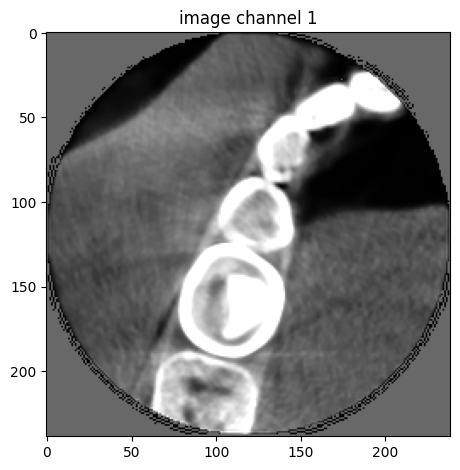

label shape: torch.Size([1, 240, 240, 155])


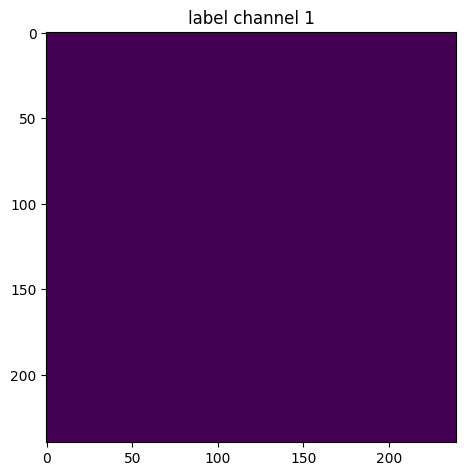

In [ ]:
"""# One image for visualization"""

print(len(train_ds))
val_data_example = val_ds[1]

print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
plt.subplot(1, 4, 1)
plt.title(f"image channel {1}")
plt.imshow(val_data_example["image"][0, :, :,85].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
plt.subplot(1, 3,1)
plt.title(f"label channel {1}")
plt.imshow(val_data_example["label"][0, :, :,85].detach().cpu())
plt.show()

In [ ]:
## Create Model, Loss, Optimizer

max_epochs = 300
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True




In [ ]:
model_dir="/content/drive/MyDrive/Cases"
model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_data_example["image"].unsqueeze(0).to(device)
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])

torch.Size([1, 240, 240, 155])


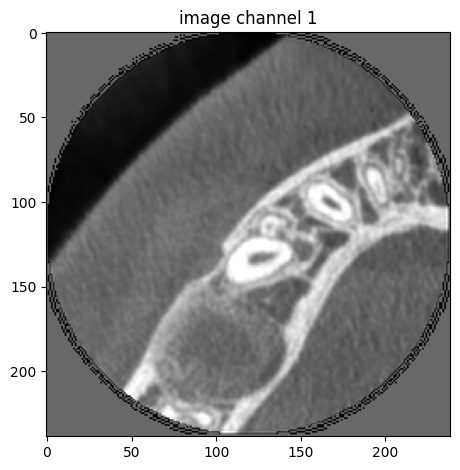

torch.Size([1, 240, 240, 155])


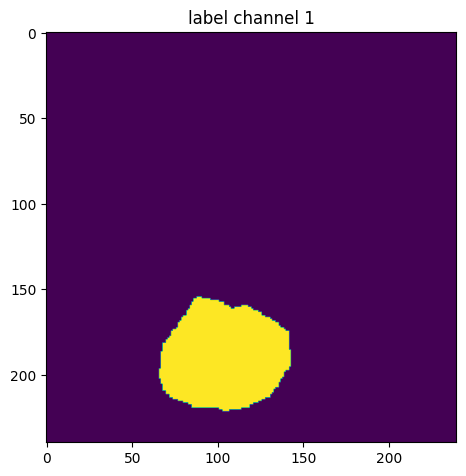

torch.Size([1, 239, 239, 155])


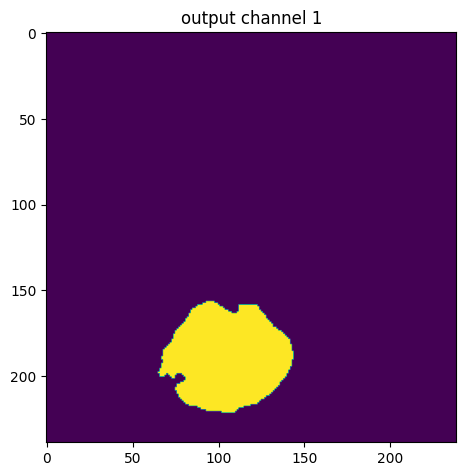

In [ ]:
print(train_ds[0]["image"].shape)
plt.figure("image", (24, 6))
plt.subplot(1, 4, 1)
plt.title(f"image channel {1}")
plt.imshow(val_data_example["image"][0, :, :,45].detach().cpu(), cmap="gray")
plt.show()
# visualize the 3 channels label corresponding to this image
print(train_ds[0]["label"].shape)
plt.figure("label", (18, 6))
plt.subplot(1, 3, 2)
plt.title(f"label channel {1}")
plt.imshow(val_data_example["label"][0, :, :, 45].detach().cpu())
plt.show()

# visualize the 3 channels model output corresponding to this image
print(val_output.shape)
plt.figure("output", (18, 6))
plt.subplot(1, 3, 3)
plt.title(f"output channel {1}")
plt.imshow(val_output[0, :, :, 45].detach().cpu())
plt.show()
